## Set working directory

In [1]:
import os
os.chdir('/local/home/mhoerold/entrack')

## Imports

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import nibabel as nib
import copy

from src.baum_vagan.vagan.model_wrapper import VAGanWrapper
from src.baum_vagan.utils import ncc
from src.data.streaming.vagan_streaming import MRIImagePair, AgeFixedDeltaStream
from src.baum_vagan.utils import map_image_to_intensity_range

## Load model for evaluation

In [ ]:
smt_label = "20180805-163029"
config_path = os.path.join("data", smt_label, "config.yaml")
model_dir = os.path.join("data", smt_label, "logdir_cont")
with open(config_path, 'r') as f:
    model_config = yaml.load(f)
wrapper = VAGanWrapper(**model_config)
wrapper.vagan.load_weights(model_dir)
vagan = wrapper.vagan

In [4]:
## Some streamers
train_stream = lambda bs: wrapper.data.trainAD.next_batch(bs)[0]
validation_stream = lambda bs: wrapper.data.validationAD.next_batch(bs)[0]
test_stream = lambda bs: wrapper.data.testAD.next_batch(bs)[0]

n_train_samples = wrapper.data.n_train_samples
n_val_samples = wrapper.data.n_val_samples
n_test_samples = wrapper.data.n_test_samples

# Input wrapper
input_wrapper = wrapper.config.input_wrapper
gt_channel = 1

In [5]:
def extract_x_t0_x_t1_delta_x_t0(batch):
    x_t0 = batch[:, :, :, :, 0:1]
    delta_x_t0 = batch[:, :, :, :, 1:2]
    x_t1 = x_t0 + delta_x_t0
    return x_t0, x_t1, delta_x_t0

## Compute scores (e.g. NCC)

In [6]:
streamers = [
    {
        "streamer": test_stream,
        "name": "test",
        "n_samples": n_test_samples
    },
    {
        "streamer": validation_stream,
        "name": "validation",
        "n_samples": n_val_samples
    },
    {
        "streamer": train_stream,
        "name": "train",
        "n_samples": n_train_samples
    }
]

for s in streamers:
    stream = s["streamer"]
    name = s["name"]
    n_samples = s ["n_samples"]
    print("Evaluating {}".format(name))
    scores = []
    for _ in range(n_samples):
        inp = stream(1)
        diff_map = vagan.predict_mask(inp)
        # wrapped = input_wrapper(inp)
        gt = inp[:, :, :, :, gt_channel:gt_channel + 1]
        sc = ncc(diff_map, gt)
        scores.append(sc)
        
    print("NCC: mean {}, std {}, median {}"
          .format(np.mean(scores), np.std(scores), np.median(scores)))

Evaluating test
NCC: mean -0.0224372186857976, std 0.13540328231001497, median -0.01636842399141125
Evaluating validation
NCC: mean -0.027382341796520143, std 0.13384027099500032, median -0.03507832959970611
Evaluating train
NCC: mean -0.01697703913185615, std 0.1385793795165965, median -0.014735088097306278


## Analyze slices of generated difference map

In [ ]:
def plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, axis, slice_idx):
    x_t1_gen = x_t0 + delta_gen
    
    x_t0 = np.squeeze(np.take(x_t0, slice_idx, axis=axis))
    x_t1 = np.squeeze(np.take(x_t1, slice_idx, axis=axis))
    delta_x_t0 = np.squeeze(np.take(delta_x_t0, slice_idx, axis=axis))
    delta_gen = np.squeeze(np.take(delta_gen, slice_idx, axis=axis))
    x_t1_gen = np.squeeze(np.take(x_t1_gen, slice_idx, axis=axis))
    
    figsize = (20, 20)
    fs = 20
    fig = plt.figure(figsize=figsize, edgecolor='black', linewidth=0.1)
    plt.subplots_adjust(hspace=0.2, bottom=0.1)
    
    ax1 = fig.add_subplot(231)
    ax1.set_title("x_t0", size=fs)
    ax1.imshow(x_t0, cmap='gray')
    
    ax2 = fig.add_subplot(232)
    ax2.set_title("delta_x_t0", size=fs)
    ax2.imshow(delta_x_t0, cmap='gray')
    
    ax3 = fig.add_subplot(233)
    ax3.set_title("x_t1", size=fs)
    ax3.imshow(x_t1, cmap='gray')
    
    ax4 = fig.add_subplot(235)
    ax4.set_title("generated delta_x_t0", size=fs)
    ax4.imshow(delta_gen, cmap='gray')
    
    ax5 = fig.add_subplot(236)
    ax5.set_title("generated x_t1", size=fs)
    ax5.imshow(x_t1_gen, cmap='gray')
    
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.axis('off')
        
    fig.tight_layout()
    
n_samples = 20
for _ in range(n_samples):
    inp = test_stream(1)
    x_t0, x_t1, delta_x_t0 = extract_x_t0_x_t1_delta_x_t0(inp)
    delta_gen = vagan.predict_mask(inp)
    x_t1_gen = x_t0 + delta_gen
    
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, 1, 35)
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, 2, 59)
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, 3, 40)

## Iterative predictions

In [ ]:
deltas = list(range(2, 11))
tol = 0.2
config = copy.deepcopy(wrapper.data.config)
delta_to_streamer = {}
for delta in deltas:
    config["delta_min"] = delta - tol
    config["delta_max"] = delta + tol
    config["normalize_images"] = False
    config["silent"] = True
    try:
        streamer = AgeFixedDeltaStream(config)
        streamer.all_pairs = streamer.train_pairs + streamer.test_pairs + streamer.val_pairs
        delta_to_streamer[delta] = streamer
    except:
        print("No streamer for delta = {}".format(delta))

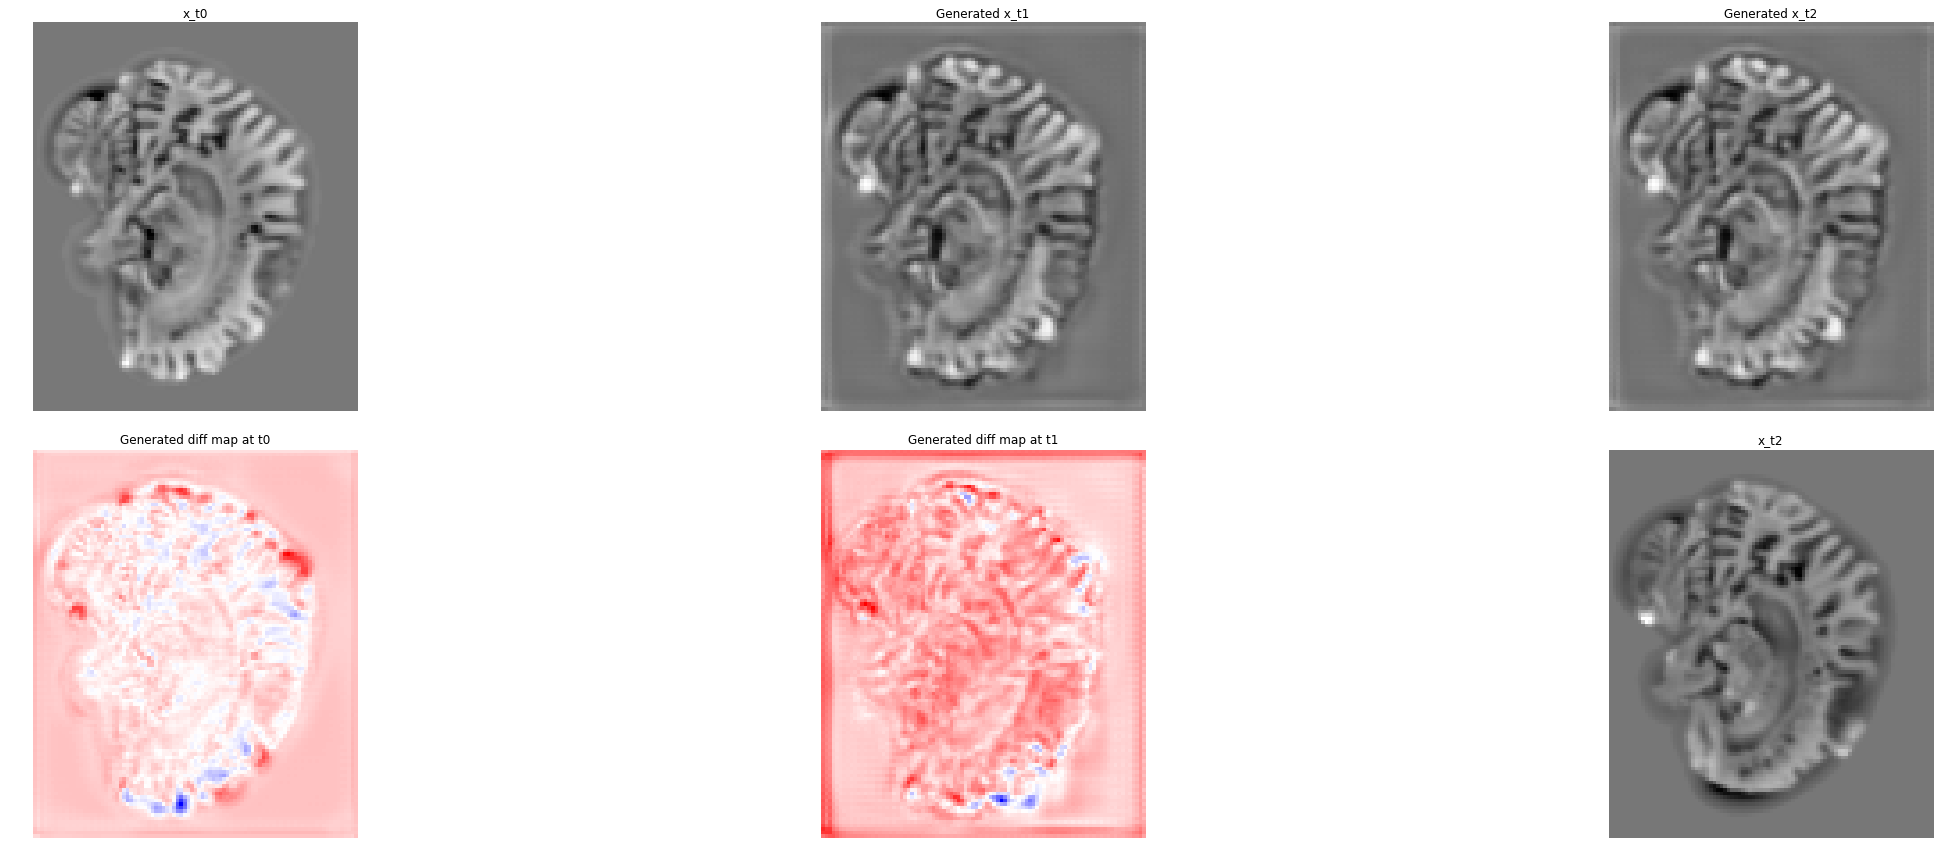

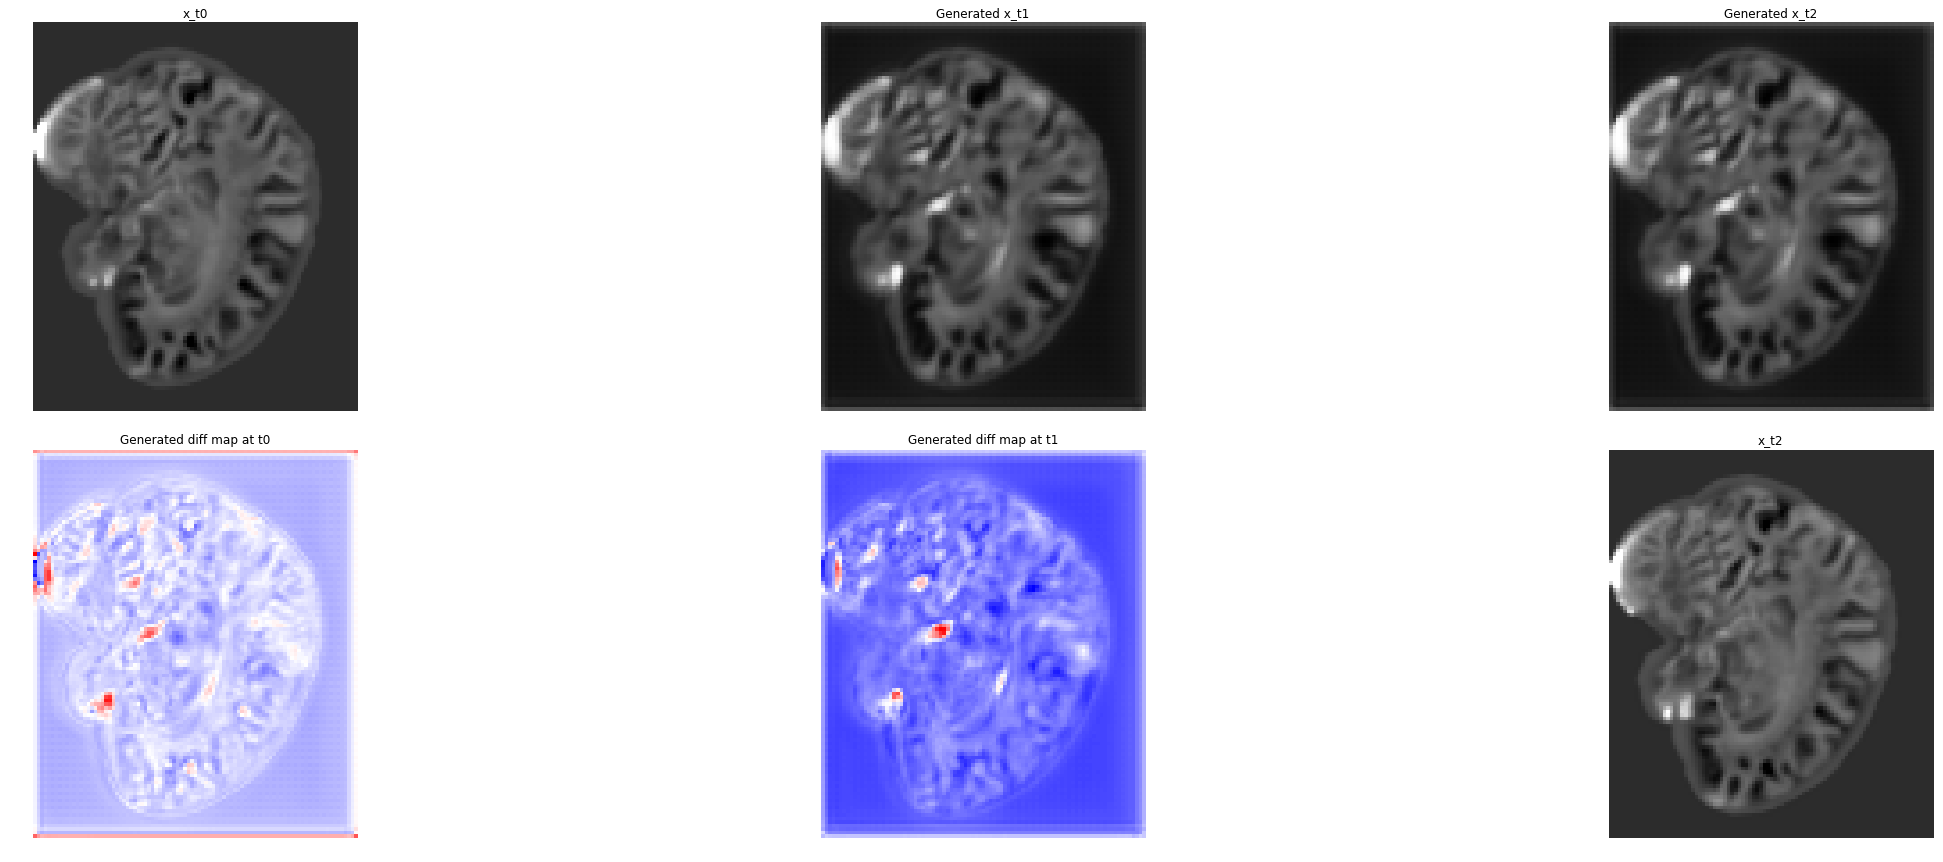

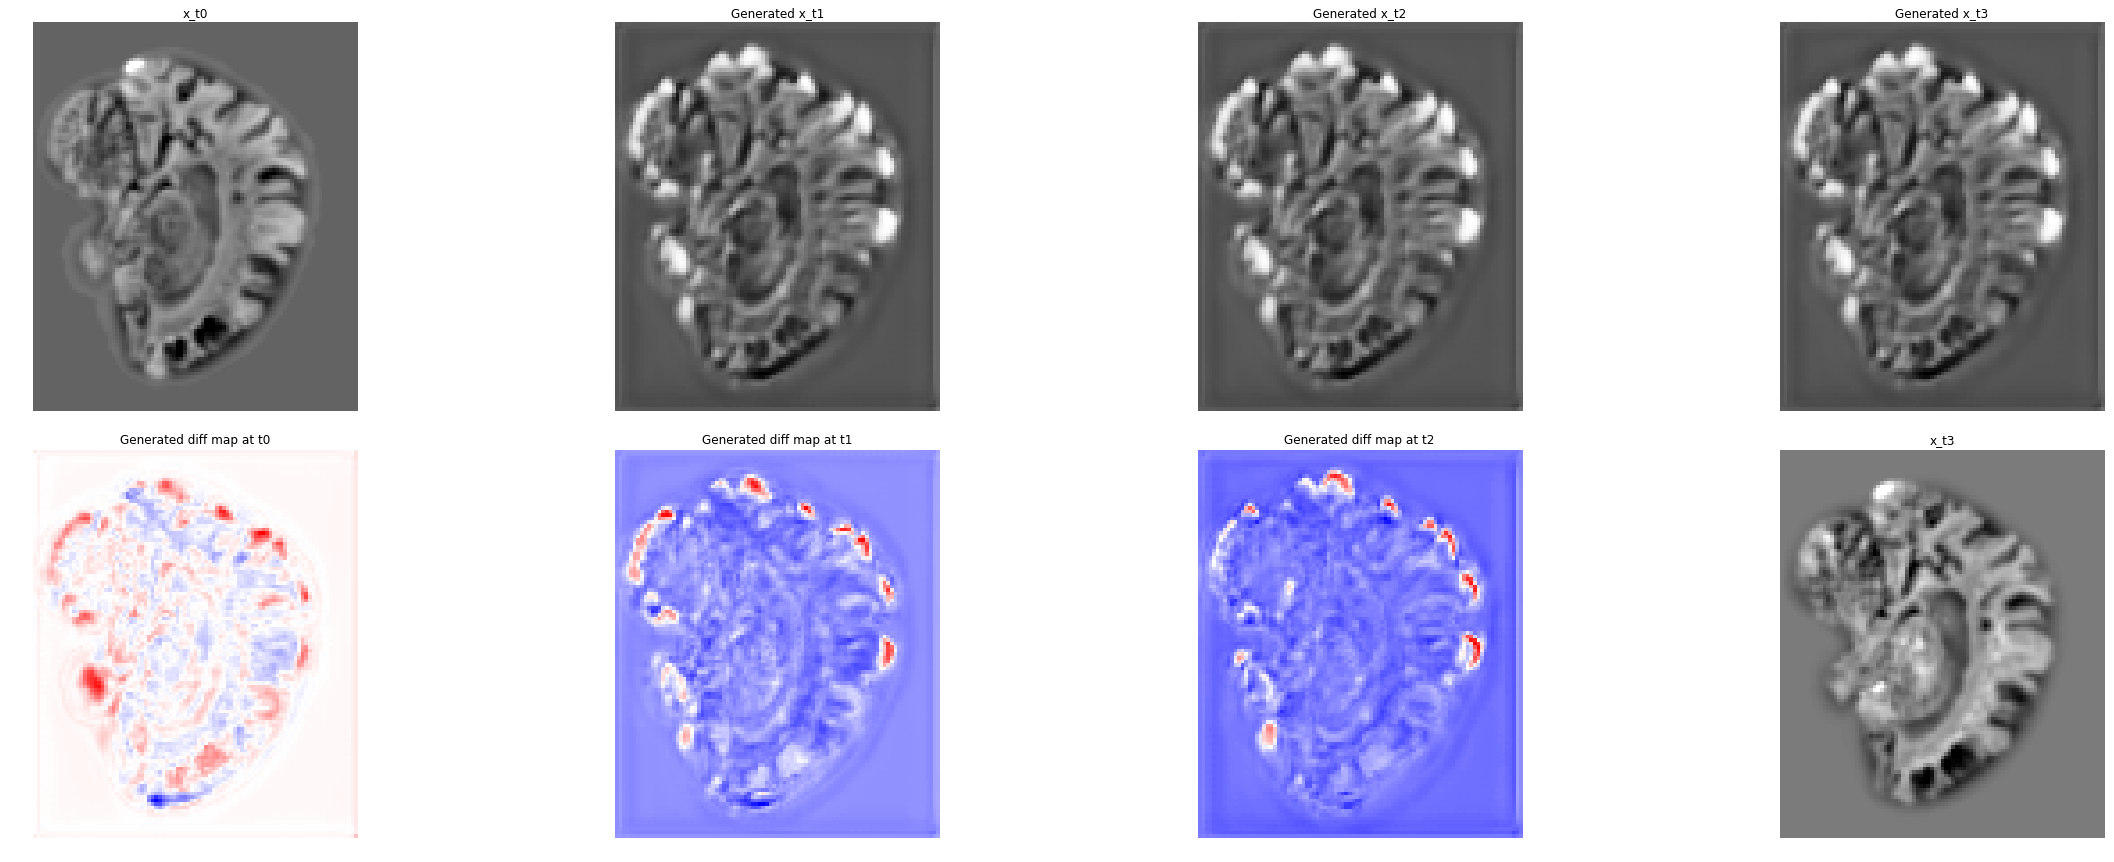

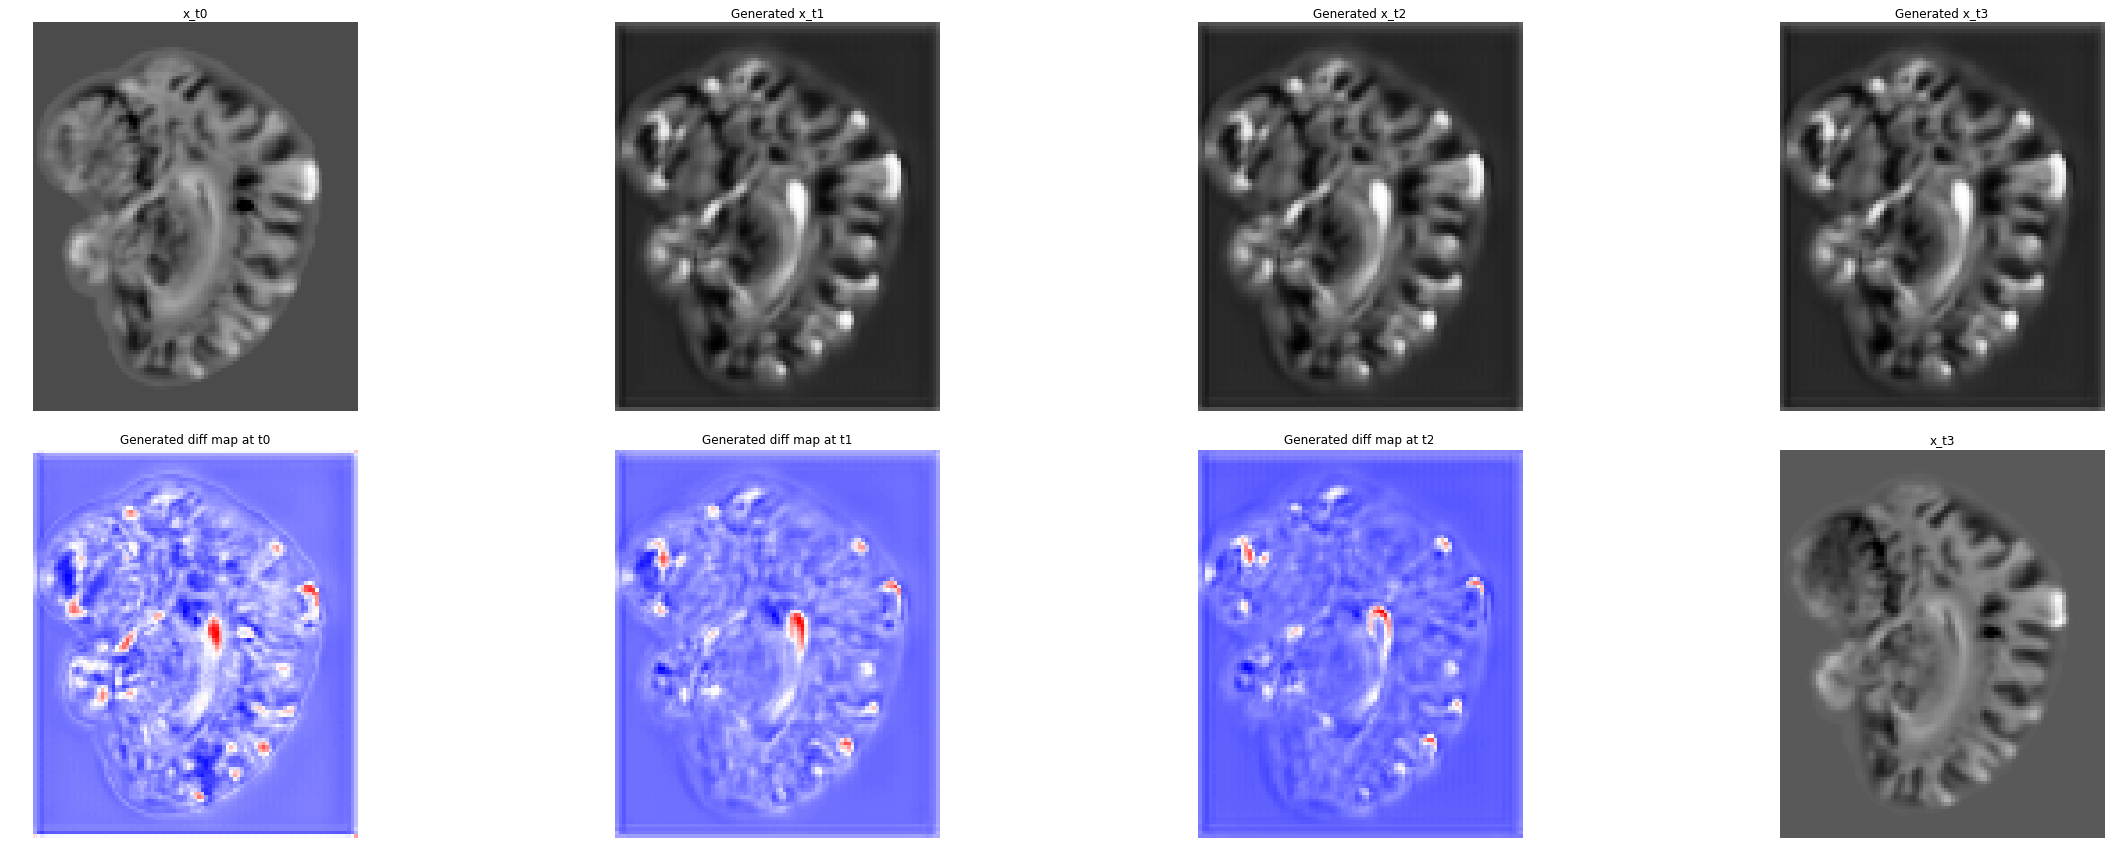

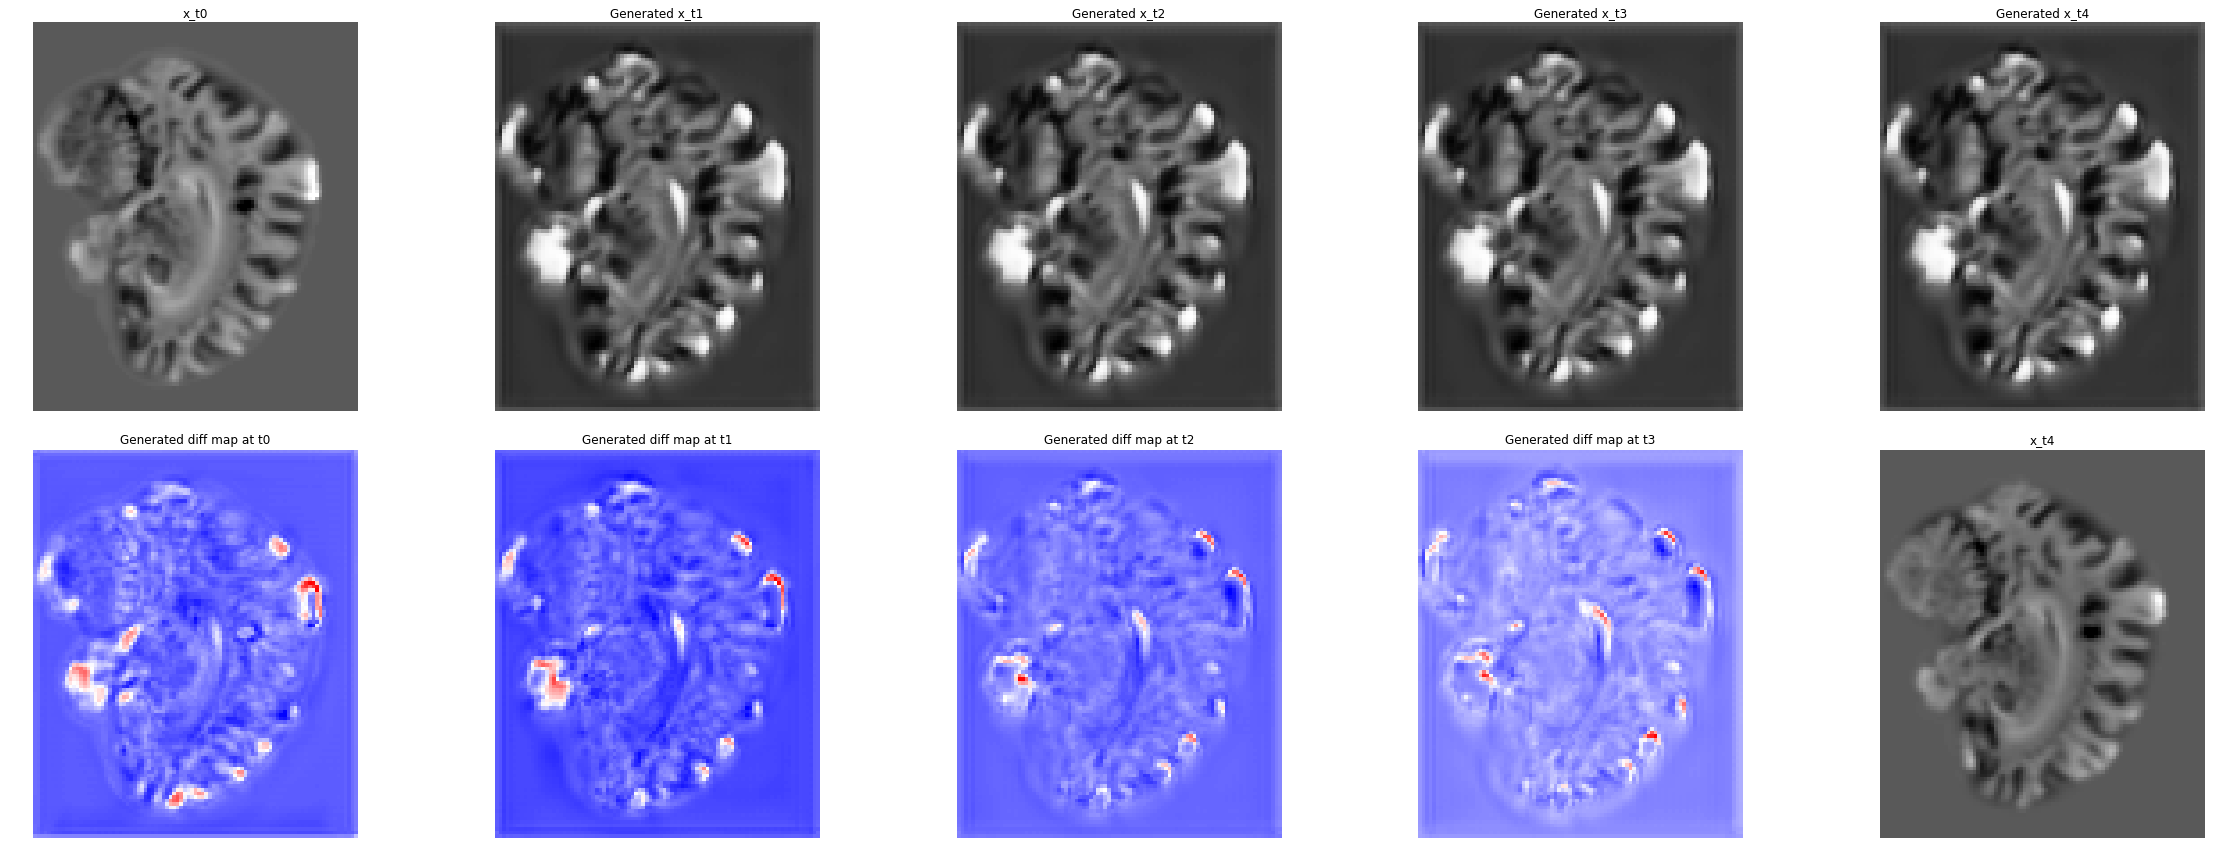

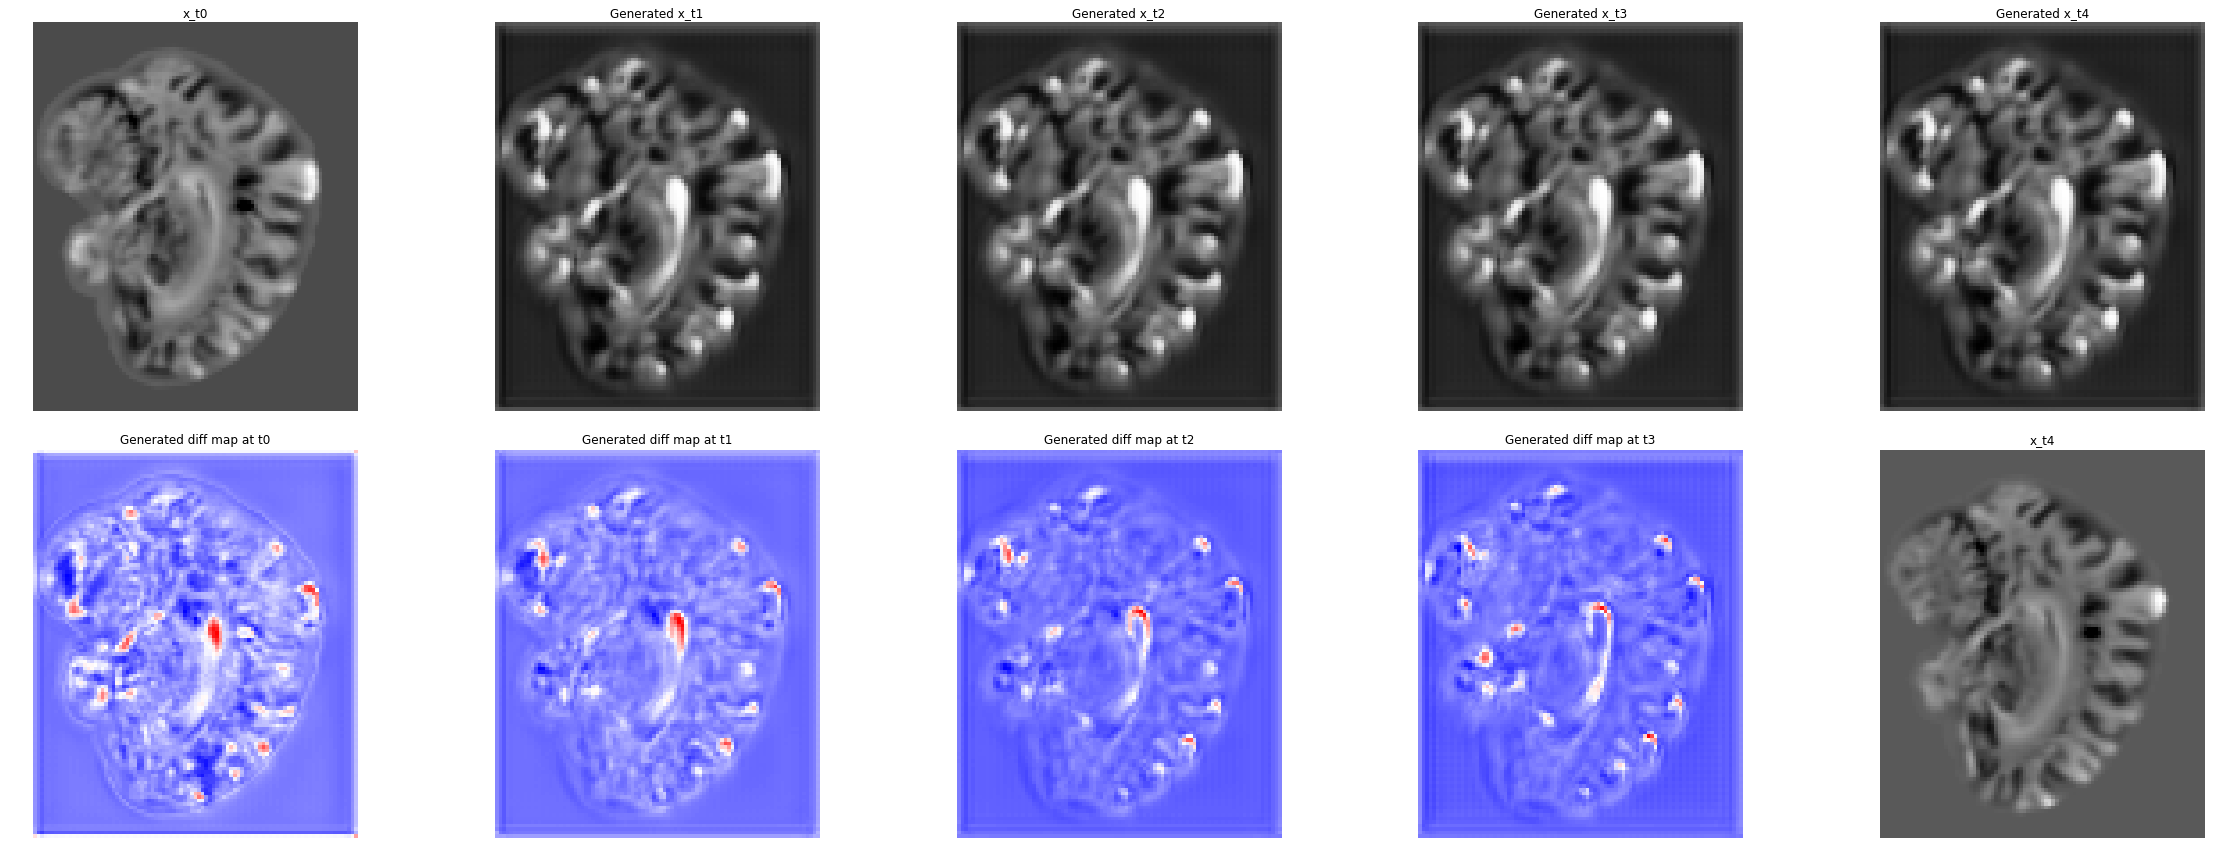

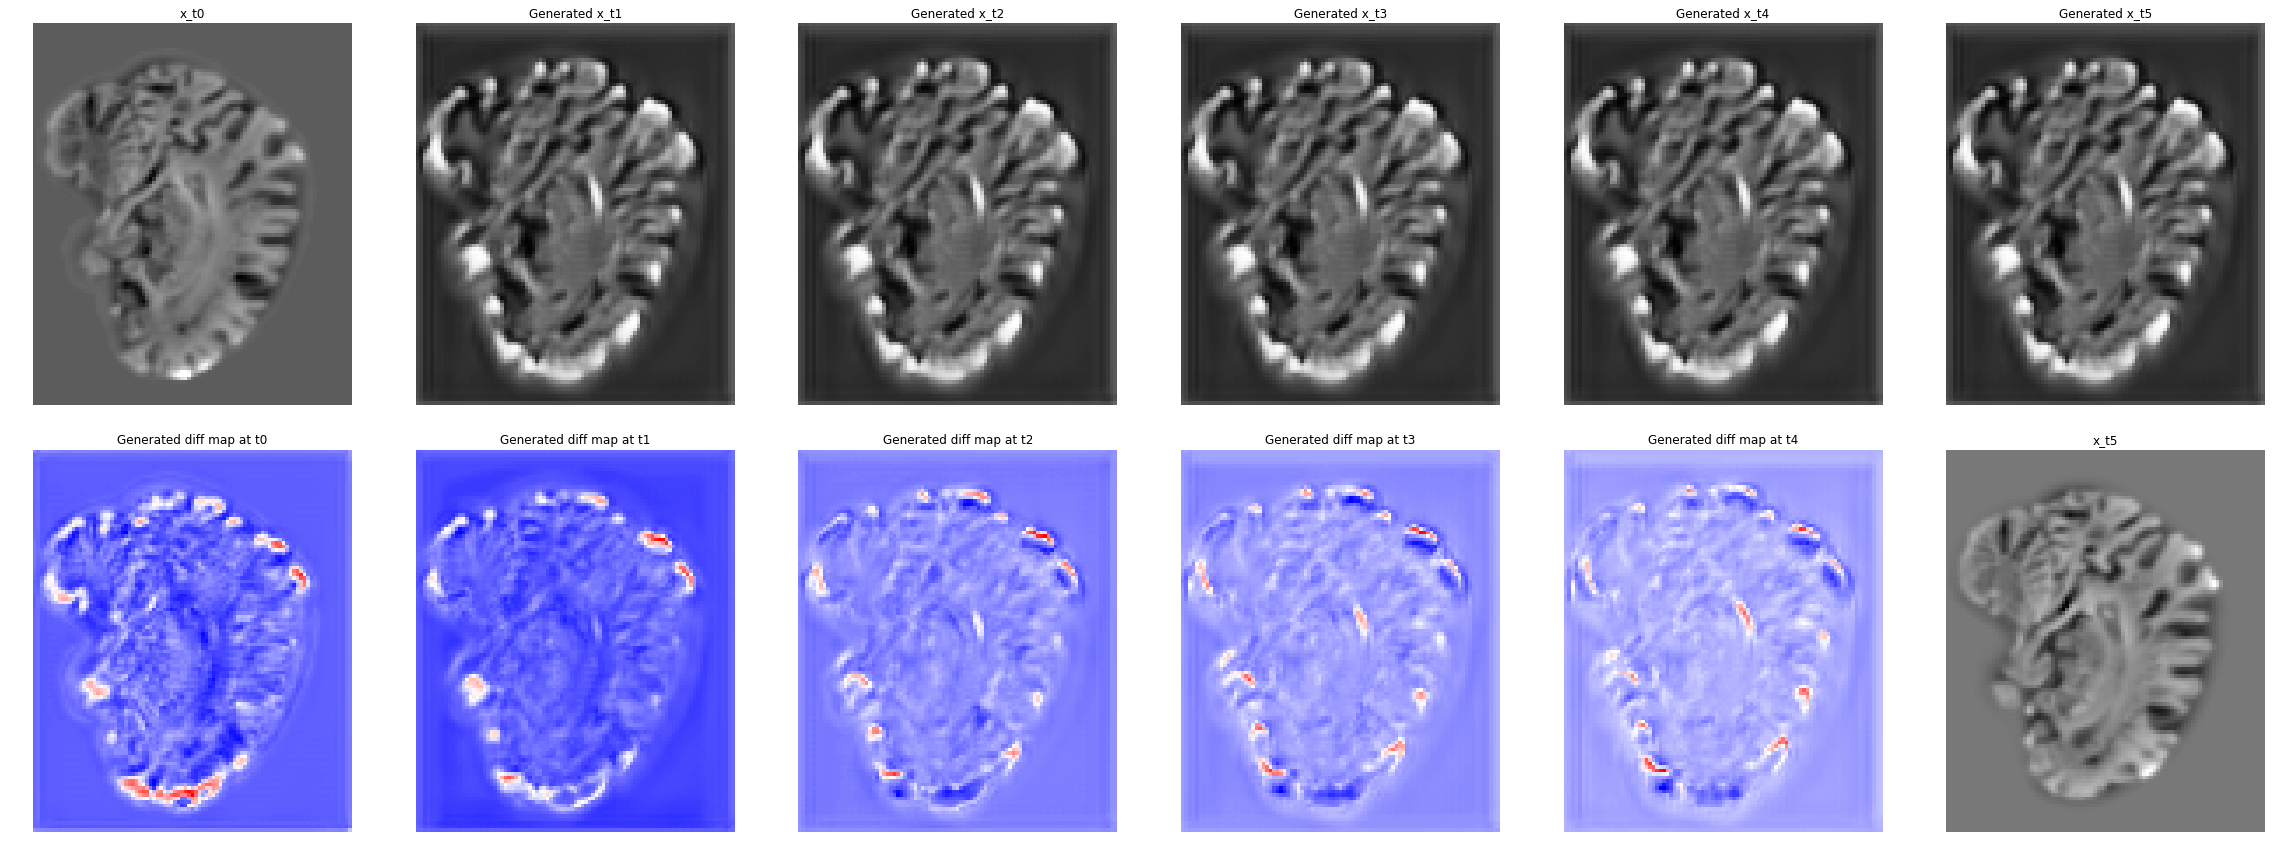

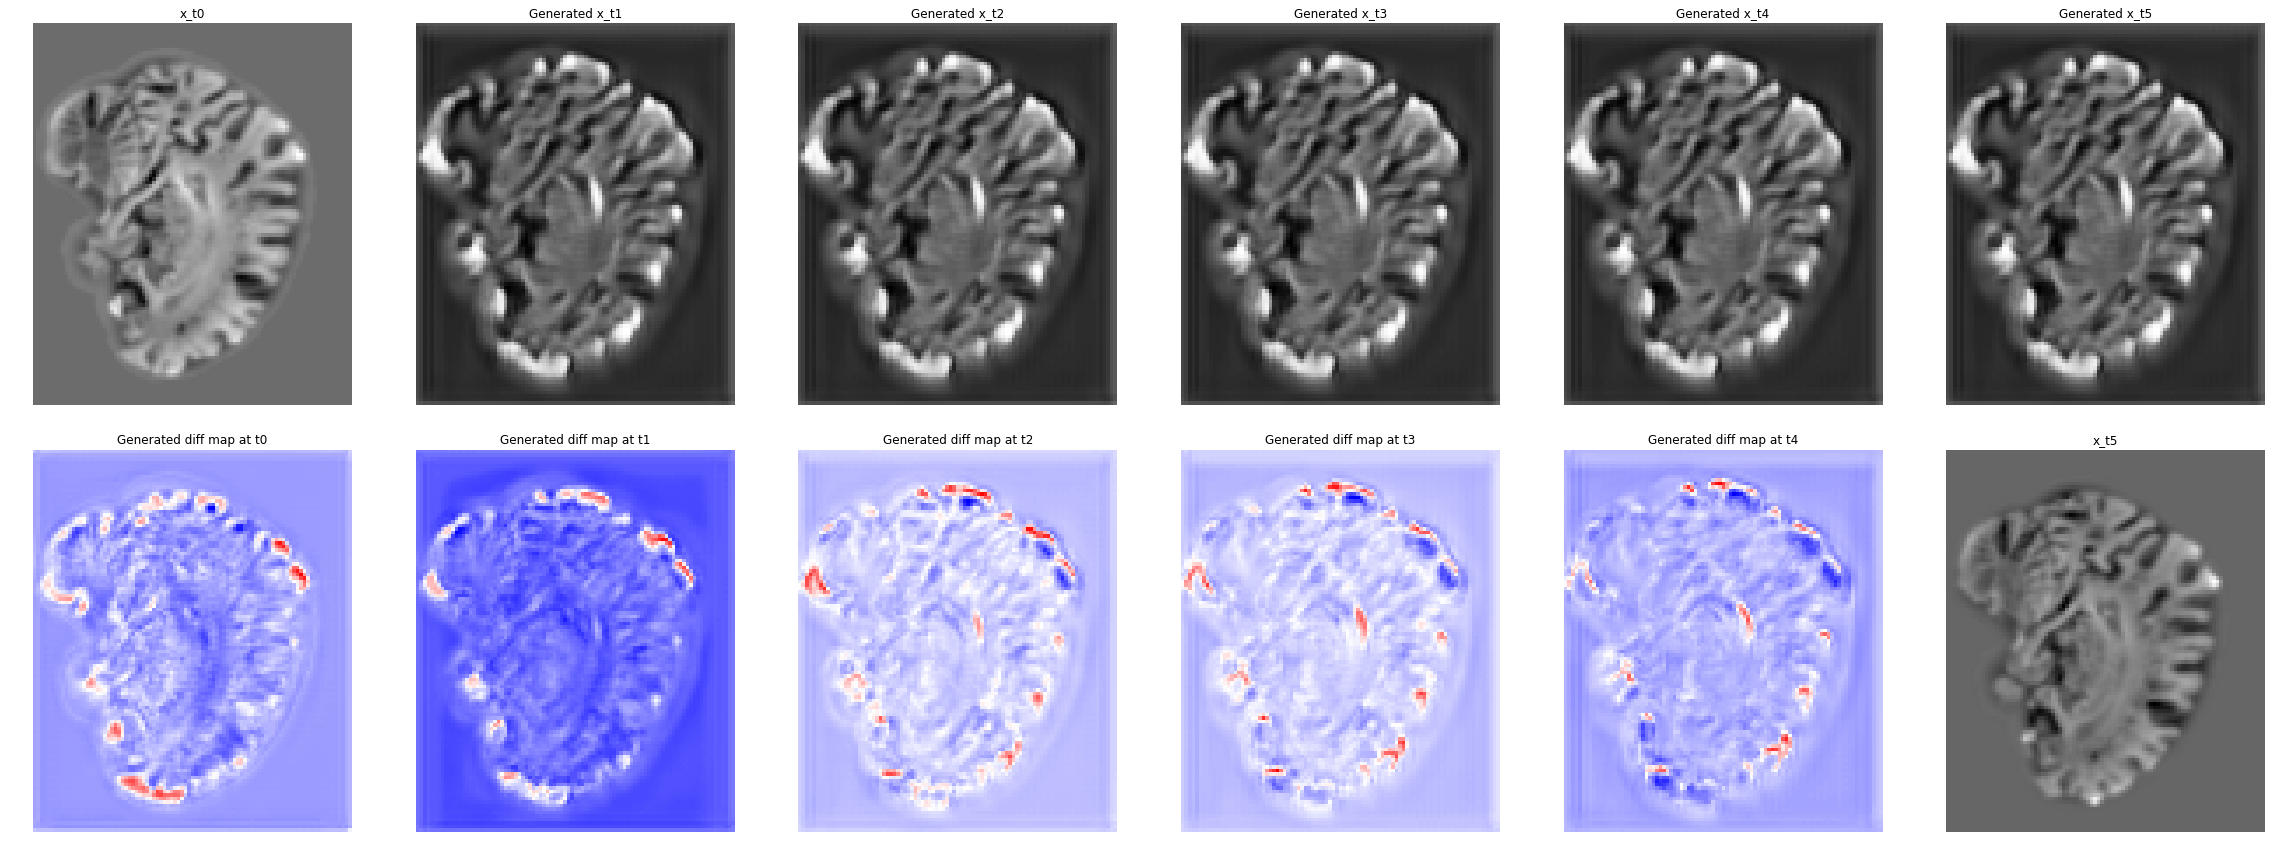

In [108]:
def iterate_model(model, img, n_steps):
    images = []
    masks = []
    # placeholder needs a second channel not used by generator
    img = np.concatenate((img, img), axis=-1)
    img = np.array([img])  # make a batch of size 1
    for _ in range(n_steps):
        M = model.predict_mask(img)
        masks.append(np.squeeze(M))
        img += M
        images.append(np.squeeze(img[:, :, :, :, 0]))
        # placeholder needs a second channel not used by generator
        # img = np.concatenate((img, img), axis=-1)
        
    return images, masks

def plot_iterative_predictions(pair, delta):
    # Use normalization of trained model
    # print(pair.get_age_delta())
    # print(pair.streamer.get_image_label(pair.fid1))
    pair = MRIImagePair(
        streamer=wrapper.data,
        fid1=pair.fid1,
        fid2=pair.fid2
    )
    x_t0 = pair.load_image(pair.fid1)
    x_tn = pair.load_image(pair.fid2)
    images, masks = iterate_model(wrapper.vagan, x_t0, delta)

    def get_slice(img):
        img = np.squeeze(img)
        return img[35, :, :]

    # plot predictions
    fig, axes = plt.subplots(2, delta + 1, figsize=(40, 15), edgecolor='black')
    # plot images
    axes[0, 0].imshow(get_slice(x_t0), cmap='gray')
    axes[0, 0].set_title("x_t0")
    for i, img in enumerate(images):
        axes[0, i + 1].imshow(get_slice(img), cmap='gray')
        axes[0, i + 1].set_title('Generated x_t{}'.format(i + 1))

    # plot masks
    for i, mask in enumerate(masks):
        axes[1, i].imshow(get_slice(mask), cmap='bwr')
        axes[1, i].set_title('Generated diff map at t{}'.format(i))

    # plot gt
    axes[1, delta].imshow(get_slice(x_tn), cmap='gray')
    axes[1, delta].set_title('x_t{}'.format(delta))

    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            axes[i, j].axis('off')

    plt.subplots_adjust(hspace=0.1)
    
for delta in range(2, 6): 
    pairs = delta_to_streamer[delta].all_pairs[:5]
    plot_iterative_predictions(pairs[1], delta)
    plot_iterative_predictions(pairs[0], delta)

In [22]:
np.squeeze(np.take(x_t0, [40], axis=2)).shape

(91, 91)

In [ ]:
test_ids = wrapper.data.get_test_ids()

for i, fid in enumerate(test_ids):
    path = wrapper.data.get_file_path(fid)
    p = MRIImagePair(wrapper.data, fid, fid)
    im = p.load_image(fid)
    lab = wrapper.data.get_image_label(fid)
    
    orig = nib.load(path).get_data()
    
    maxi = np.percentile(orig, 90)
    clipped = np.clip(orig, 0, 500)
    clipped_normed = wrapper.data.normalize_image(clipped)
    
    fig = plt.figure()
    plt.title("{}, min {}, max {}, std {}, 95perc {}".format(lab, np.min(orig), np.max(orig), np.std(orig), np.percentile(orig, 95)))
    ax1 = fig.add_subplot(131)
    ax1.imshow(im[:, 59, :, 0], cmap='gray')
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(orig[:, 59, :], cmap='gray')
    
    ax3 = fig.add_subplot(133)
    ax3.set_title("std {}".format(np.std(clipped)))
    ax3.imshow(clipped_normed[:, 59, :], cmap='gray')
    

In [104]:
all_ids = wrapper.data.get_validation_ids().union(wrapper.data.get_test_ids()).union(wrapper.data.get_train_ids())

In [105]:
len(all_ids)

1737

In [106]:
high_stds = []
maxis = []
for fid in all_ids:
    im = wrapper.data.load_image(fid)
    std = np.std(im)
    maxis.append(np.max(im))
    if std > 1200:
        high_stds.append(fid)

In [13]:
len(high_stds)

16

In [ ]:
for fid in high_stds:
    lab = wrapper.data.get_image_label(fid)
    fig = plt.figure()
    plt.title(fid)
    im = wrapper.data.load_image(fid)
    ax1 = fig.add_subplot(131)
    ax1.imshow(im[:, 59, :], cmap='gray')
    
    normed = wrapper.data.normalize_image(im)
    ax2 = fig.add_subplot(132)
    ax2.imshow(normed[:, 59, :], cmap='gray')

In [94]:
fid = '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/60125_mni_aligned.nii.gz'
cur = wrapper.data.load_image(fid)

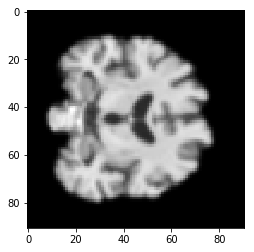

In [95]:
plt.imshow(cur[:, 59, :], cmap='gray')

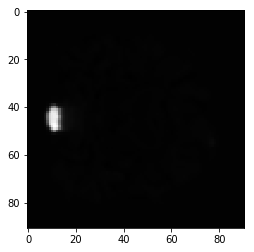

In [96]:
normed = wrapper.data.normalize_image(cur)
plt.imshow(normed[:, 59, :], cmap='gray')

(array([4456.,  190.,  190.,  278.,  316.,  454.,  570.,  813.,  990.,
          24.]),
 array([   0.        ,  462.58076172,  925.16152344, 1387.74228516,
        1850.32304688, 2312.90380859, 2775.48457031, 3238.06533203,
        3700.64609375, 4163.22685547, 4625.80761719]),
 <a list of 10 Patch objects>)

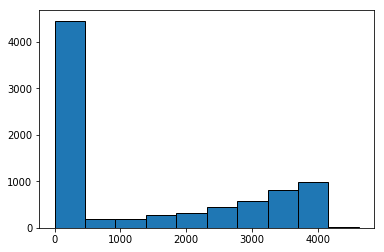

In [8]:
plt.hist(np.reshape(cur[:, 59, :], (-1, 1)), edgecolor='black')

(array([2.085e+03, 6.009e+03, 5.800e+01, 2.800e+01, 1.900e+01, 3.200e+01,
        2.900e+01, 8.000e+00, 3.000e+00, 1.000e+01]),
 array([-4.97628897, -0.17237927,  4.63153042,  9.43544011, 14.23934981,
        19.0432595 , 23.84716919, 28.65107888, 33.45498858, 38.25889827,
        43.06280796]),
 <a list of 10 Patch objects>)

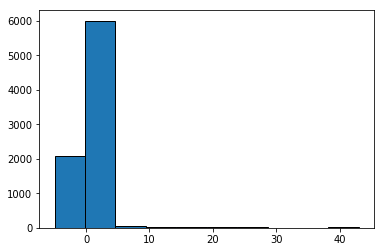

In [9]:
plt.hist(np.reshape(normed[:, 59, :], (-1, 1)), edgecolor='black')

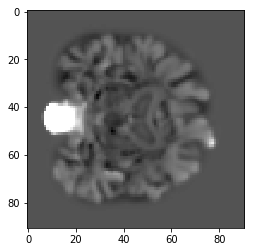

In [14]:
plt.imshow(np.clip(normed[:, 59, :], -10, 10), cmap='gray')

In [11]:
import inspect
lines = inspect.getsource(wrapper.data.normalize_image)
print(lines)

    def normalize_image(self, im):
        assert self.normalization_computed
        std = np.std(im)
        if np.isclose(0, std):
            std = 1
        im = (im - np.mean(im)) / std
        im = (im - self.voxel_means) / self.voxel_stds
        std = np.std(im)
        if np.isclose(0, std):
            std = 1
        im = (im - np.mean(im)) / std
        return im



In [99]:
def normalize_image(im):
    plt.figure()
    plt.imshow(im[:, 59, :], cmap='gray')
    std = np.std(im)
    print(std)
    if np.isclose(0, std):
        std = 1
        print("1: std is close to 0")
    im = (im - np.mean(im)) / std
    plt.figure()
    plt.imshow(im[:, 59, :], cmap='gray')
    plt.figure()
    plt.hist(np.reshape(im[:, 59, :], (1, -1)).ravel(), edgecolor='black')
    plt.show()
    im = (im - wrapper.data.voxel_means) / wrapper.data.voxel_stds
    plt.figure()
    plt.hist(np.reshape(im[:, 59, :], (1, -1)).ravel(), edgecolor='black')
    plt.show()
    plt.figure()
    plt.imshow(im[:, 59, :], cmap='gray')
    std = np.std(im)
    print(std)
    if np.isclose(0, std):
        std = 1
        print("2: std is close to 0")
    im = (im - np.mean(im)) / std
    plt.figure()
    plt.imshow(im[:, 59, :], cmap='gray')
    return im

1338.4634


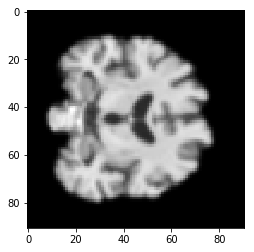

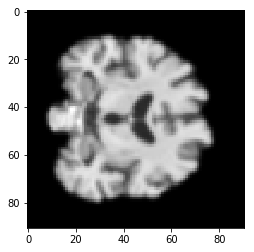

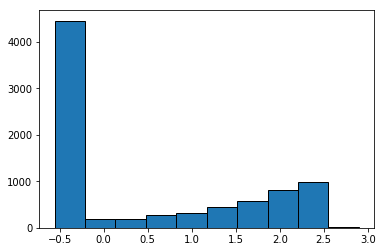

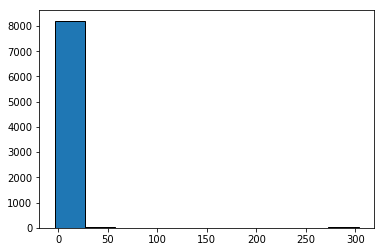

4.4738308182784765


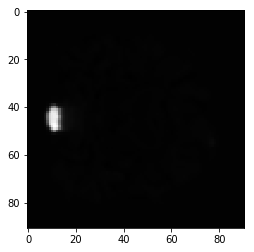

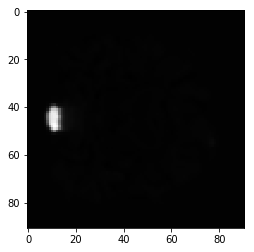

In [100]:
s = normalize_image(cur)

In [20]:
np.mean(cur)

745.2123

In [33]:
len(maxis)

1737

In [34]:
np.max(maxis)

5143.8975

(array([1219.,  239.,   76.,  105.,   64.,    8.,    4.,    6.,   14.,
           2.]),
 array([  47.84764481,  557.45262642, 1067.05760803, 1576.66258965,
        2086.26757126, 2595.87255287, 3105.47753448, 3615.0825161 ,
        4124.68749771, 4634.29247932, 5143.89746094]),
 <a list of 10 Patch objects>)

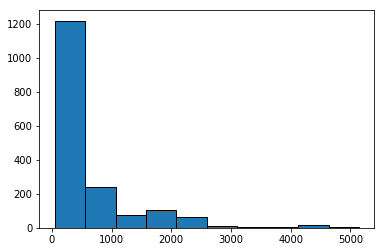

In [35]:
plt.hist(maxis, edgecolor='black')

In [37]:
maxi_perc = np.percentile(maxis, 95)

141.64664


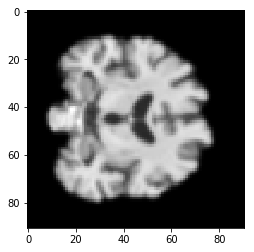

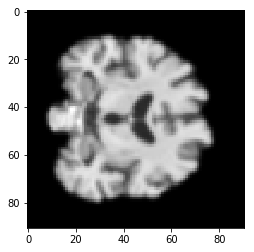

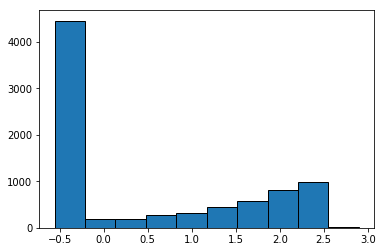

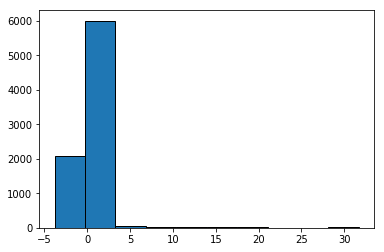

0.7392471879057763


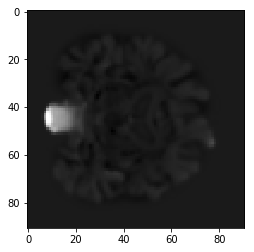

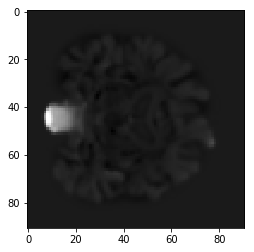

In [61]:
s = normalize_image(map_image_to_intensity_range(cur, 0, np.percentile(maxis, 70)))

1320.1125


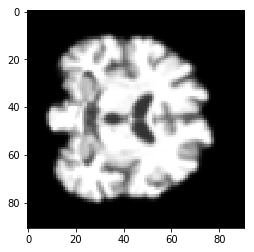

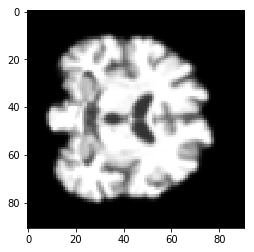

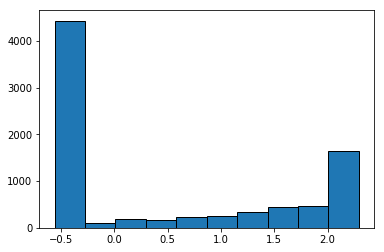

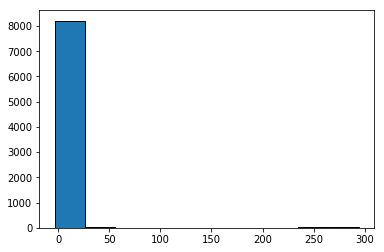

4.3683307831105855


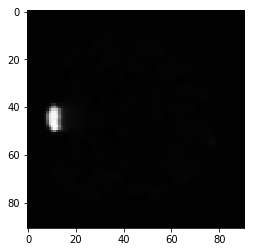

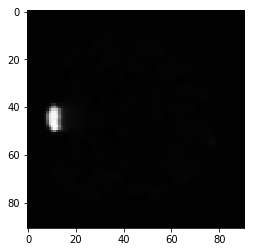

In [107]:
s = normalize_image(np.clip(cur, 0, np.percentile(cur, 95)))

In [42]:
np.percentile(cur, 95)

3763.848681640624